In [1]:
# first test for polyphonic music
import librosa
import numpy as np
import os
from sporco.admm import cbpdn
import sporco.metric as sm
import pickle 
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.signal import argrelextrema
import scipy.io.wavfile
import math
from copy import deepcopy
sr = 11025
window_size = 0.050

In [2]:
# load the dictionary for the individual notes
D = []
directory = './maps/notes/'

for i in range(21,109):
    fname1 = 'MAPS_ISOL_NO_F_S0_M' + str(i) + '_SptkBGCl.wav'
    fname2 = 'MAPS_ISOL_NO_F_S1_M' + str(i) + '_SptkBGCl.wav'
    
    try:
        s = librosa.load(directory + fname1, sr=11025,offset=0.7,duration=1.0)[0]
    except:
        s = librosa.load(directory + fname2, sr=11025,offset=0.7,duration=1.0)[0]
    # normalize dictionary elements
    D.append(s/np.amax(s))
    
D = np.asarray(D)
D = D.T

with open('mapsdict.pkl','wb') as fid:
     pickle.dump(D,fid)

In [ ]:
#solve the CBPDN problem
with open('mapsdict.pkl','rb') as fid:
    D = pickle.load(fid)
print(D.shape)
lmbda = 0.005
# 1 temporal dimension
dimN = 1

opt = cbpdn.ConvBPDN.Options({'Verbose' : True, 'MaxMainIter' : 500,
                    'HighMemSolve' : True, 'LinSolveCheck' : True,
                    'RelStopTol' : 1e-3, 'AuxVarObj' : False})

songdir = "./maps/songs/"
songname = "MAPS_MUS-alb_esp2_SptkBGCl.wav"
song, sr = librosa.load(songdir+songname,sr=sr)

b = cbpdn.ConvBPDN(D, song, lmbda, opt,dimN=dimN)
X = b.solve()
X = X[:,0,0,:]
with open('maps_results_esp2.pkl', 'wb') as fid:
    pickle.dump(X, fid)

In [3]:
# load the GT of the song 
songdir = "./maps/songs/"
songname = "MAPS_MUS-alb_esp2_SptkBGCl.wav"
song, sr = librosa.load(songdir+songname,sr=sr)

f = open(songdir + 'MAPS_MUS-alb_esp2_SptkBGCl.txt', 'rb')
lines = f.readlines()[1:]
GT = {}
num_timesets = 0
for row in lines:
    row = row.decode().strip('\r\n')
    row = row.split('\t')
    if row[2] in GT:
        GT[row[2]].append([row[0], row[1]])
    else:
        GT[row[2]] = [[row[0], row[1]]]
    num_timesets += 1


In [4]:
# peak detection for each time stamp
# find threshold to denoise the peaks 
with open('maps_results_esp2.pkl','rb') as Y:
    Y = pickle.load(Y)
    
duration = song.shape[0]/sr
lmaxes = np.asarray([])
for row in Y:
    relex = argrelextrema(row,np.greater)[0]
    lmaxes = np.concatenate((lmaxes,row[relex]))

p75,p25 = np.percentile(lmaxes, [75,25])

threshold = p75 + 12*(p75-p25)

print('threshold is', threshold)
# new array of only below threshold
lowvals = Y < threshold
Y[lowvals] = 0

threshold is 0.00183084793389


In [5]:
# num notes in the transcription that were correctly detected
def correction_pct(relex, t, numtotal, numcorrect):
    for note in relex:
        note += 21
        numtotal += 1
        if str(note) in GT:
            time_ranges = GT[str(note)]
            for time_range in time_ranges:
                s = float(time_range[0])
                e = float(time_range[1])
                if t < s - window_size:
                    break
                elif t >= s - window_size and t <= e + window_size:
                    print("in range")
                    numcorrect += 1
                    break              
    return numcorrect, numtotal

In [6]:
# num notes in GT that appear in the transcription
def GTdetected(relex, t, numpoped, GT_cp):
    for note in relex:
        note += 21
        if str(note) in GT_cp:
            time_ranges = deepcopy(GT_cp[str(note)]) 
            num_timeranges = len(time_ranges)
            for i in range(num_timeranges):
                s = float(time_ranges[i][0])
                e = float(time_ranges[i][1])
                if t < s - 0.05:
                    break
                elif t >= s - 0.05 and t <= e + 0.05:
                    # GT detected, remove
                    print(len(time_ranges))
                    GT_cp[str(note)] = time_ranges.pop(i)
                    print(len(GT_cp[str(note)]))
                    numpoped += 1
                    break
    return numpoped, GT_cp

In [7]:
# vars intialization for parsing the 50ms windows
window_size = 0.05
start = 0
l = int(sr*window_size)
end = l
window = 0

# 2D array that represents onsets
onsets = np.zeros((88,int(duration/0.05)))
# highest and lowest note (for plotting purposes)
highnote = 0
lownote = 100
total = 0
correct = 0
poped = 0
GT_cpy = deepcopy(GT)

for i in range(int(duration/window_size)):
    row = Y[start:end,:]
    #print(row.shape)
    sumrow = np.sum(row,axis=0)
    relex = argrelextrema(sumrow,np.greater)[0]
    if(len(relex) != 0):
        # time index that the note occurs
        high = np.amax(relex)
        low = np.amin(relex)
        if high > highnote:
            highnote = high
        if low < lownote:
            lownote = low
        tindex = window
        onsets[relex,tindex] = 1
        t = window_size * window
        for note in relex:
            note += 21
            total += 1
            if str(note) in GT:
                time_ranges = GT[str(note)]
                for time_range in time_ranges:
                    s = float(time_range[0])
                    e = float(time_range[1])
                    if t < s - window_size:
                        break
                    elif t >= s - window_size and t <= e + window_size:
                        correct += 1
                        break
        for note in relex:
            note += 21
            if str(note) in GT_cpy:
                time_ranges = deepcopy(GT_cpy[str(note)]) 
                for i in range(len(time_ranges)):
                    s = float(time_ranges[i][0])
                    
                    e = float(time_ranges[i][1])
                    if t < s - window_size:
                        break
                    elif t >= s - window_size and t <= e + window_size:
                        time_ranges.pop(i)
                        GT_cpy[str(note)] = time_ranges
                        poped += 1
                        break
    start = end
    end += l
    window+=1

correct_percentage = float(correct) / total
print ("Correct percentage is: " + str(correct_percentage))

undetected_percentage = float(num_timesets - poped) / num_timesets
print ("Undetected percentage is: " + str(undetected_percentage))

Correct percentage is: 0.8666666666666667
Undetected percentage is: 0.9705449189985272


In [8]:
# plot ground truth
# print(GT)
# get the ground truth for the same duration as onsets
lasttime = onsets.shape[-1] * window_size
gt_plot = np.zeros(onsets.shape)
for key in GT:
    # MIDI notes are offset by 21
    note = int(key) - 21
    # val is array of arrays, where val[i] denotes the ith [onset,offset]
    val = GT[key]
    # for each onset/offset pair
    for oopair in val:
        start = float(oopair[0])
        if start < lasttime:
            # round nearest 50ms interval
            #print(note)
            t_index = math.floor(start/window_size)
            gt_plot[note,t_index] = 1

In [9]:
for i in range(onsets.shape[1]-1):
    curr = onsets[:,i]
    nxt = onsets[:,i+1]
    # take differnce of two frames
    chnge = nxt - curr
    # where chnge = 0, we want to set next to 0
    indices = chnge < 1
    onsets[indices,i+1] = 0
# change to 2d array
x1 = []
y1 = []
x2 = []
y2 = []
for i in range(onsets.shape[1]):
        col1 = onsets[:,i]
        col2 = gt_plot[:,i]
        # get indices where note is playing
        counter = 0
        for c1 in col1:
            if c1:
                x1.append(i)
                y1.append(counter)
            counter +=1
        counter = 0
        for c2 in col2:
            if c2:
                x2.append(i)
                y2.append(counter)
            counter+=1

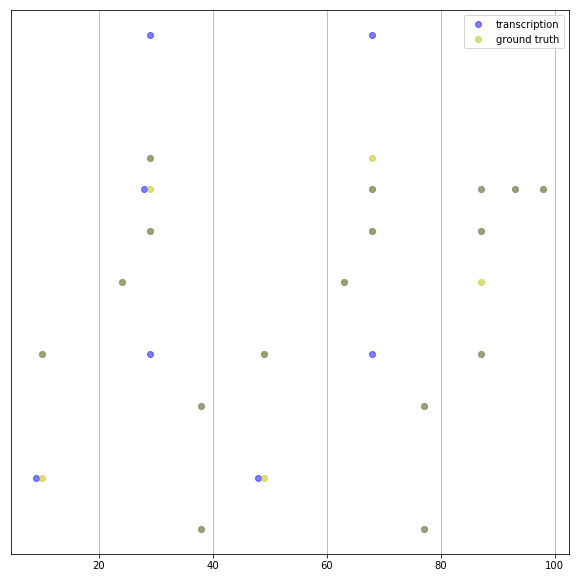

In [10]:
fig = plt.figure(figsize=(10,10))
plt.plot(x1,y1,'bo',alpha=0.5,label = 'transcription')
plt.plot(x2,y2,'yo',alpha=0.5,label = 'ground truth')
plt.legend(loc = "upper right")
ax = fig.add_subplot(1,1,1)
major_ticks = np.arange(low,high)
ax.set_yticks(major_ticks)
ax.grid(True)
plt.show()

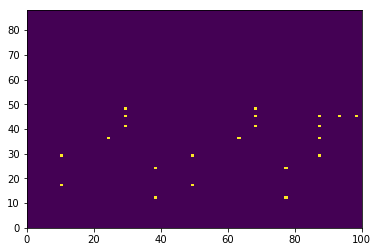

In [11]:
plt.pcolormesh(gt_plot)